In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(y, x) for x, y in zip(layers[:-1], layers[1:])]
        self.biases = [np.random.randn(y, 1) for y in layers[1:]]

    def feedforward(self, X):
        activation = X
        activations = [X]  # List to store all the activations, layer by layer
        zs = []  # List to store all the z vectors, layer by layer

        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        return activations, zs

    def backprop(self, X, y):
        activations, zs = self.feedforward(X)
        delta = (activations[-1] - y) * sigmoid_derivative(activations[-1])
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)
        
        for l in range(2, len(self.layers)):
            z = zs[-l]
            sp = sigmoid_derivative(activations[-l])
            delta = np.dot(self.weights[-l+1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].T)
        
        return nabla_b, nabla_w

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
    
        for x, y in mini_batch:
            # Debugging print statements
            
            x = np.reshape(x, (self.layers[0], 1))
            y = np.reshape(y, (self.layers[-1], 1))
            
            
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            # Accumulate the gradient from this batch
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        # Update weights and biases
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def train(self, training_data, epochs, mini_batch_size, eta):
        n = len(training_data)
        for j in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)



def load_data(file_name):
    data = pd.read_csv(file_name, sep="\t", header=None)
    data = data.apply(pd.to_numeric, errors='coerce')
    return data

def normalize_data(data):
    data = data.dropna()
    return (data - data.min()) / (data.max() - data.min())

def split_features_targets(data, target_column=-1):
    X = data.iloc[:, :target_column].values
    y = data.iloc[:, target_column].values.reshape(-1, 1)
    return X, y

# Split data into training, validation, and test sets
def split_dataset(X, y, test_size=0.2, val_size=0.1):
    # Split the data into training+validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size)
    # Adjust validation size based on the remaining training data
    val_size_adjusted = val_size / (1 - test_size)  
    # Split the training+validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size_adjusted)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Main function to run the neural network
def main():
    # Load and preprocess the data
    data = load_data("/Users/dorkol/Desktop/A1-synthetic.txt")  
    normalized_data = normalize_data(data)
    X, y = split_features_targets(normalized_data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)

    X_train = np.atleast_2d(X_train)
    y_train = np.atleast_2d(y_train)

    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)


    # Initialize and train the neural network
    nn = NeuralNetwork([X_train.shape[1], 10, 1])  # Example architecture
    nn.train(list(zip(X_train, y_train)), epochs=100, mini_batch_size=10, eta=0.1)
    
    # Evaluate the neural network
    predictions = []
    for x in X_test:
        x = x.reshape(-1, 1)  # Reshape x to be a column vector (9, 1)
        output_activations = nn.feedforward(x)[-1]
        predictions.append(output_activations[-1][0])  # Get the scalar value from the output

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_test, np.array(predictions))
    print(f'Mean Absolute Percentage Error on Test Set: {mape}%')
    bp_results = np.column_stack((y_test.flatten(), predictions))
    np.savetxt('/Users/dorkol/Desktop/bp_synthetic_result.txt', bp_results, delimiter='\t', header='Real Value (z)\tPrediction (y)', comments='')


In [19]:
main()

Mean Absolute Percentage Error on Test Set: 381.69411868886505%


In [2]:
# MLR
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

dataset = pd.read_csv('/Users/dorkol/Desktop/A1-synthetic.txt', sep='\t')

# Separate features (X) and target variable (y)
X = dataset.iloc[:, :-1]  # Features (all columns except the last one)
y = dataset.iloc[:, -1]   # Target variable (last column)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Optionally, you can print the coefficients and intercept
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Mean Squared Error: 0.4120515202077409
R-squared: 0.9736374087542181
Coefficients: [-1.94658530e-04  1.32796072e+00  8.77149422e-02  4.79144641e-01
 -1.64113318e-01 -1.63860103e-01  1.63843885e-01  1.01507470e+00
  9.90079439e-01]
Intercept: -19.40691830115742


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

dataset = pd.read_csv('/Users/dorkol/Desktop/A1-synthetic.txt', sep='\t')

X = dataset.iloc[:, :-1]  
y = dataset.iloc[:, -1]   

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# --- Multilinear Regression ---

mlr_model = LinearRegression()

# Fit the model on the training data
mlr_model.fit(X_train, y_train)

# Make predictions on the validation set
mlr_val_pred = mlr_model.predict(X_val)

# Make predictions on the test set
mlr_test_pred = mlr_model.predict(X_test)


mlr_results = pd.DataFrame({'Real Value (z)': y_test, 'Prediction (y)': mlr_test_pred})
mlr_results.to_csv('/Users/dorkol/Desktop/mlr_synthetic_result.txt', sep='\t', index=False)
# Calculate MAPE for MLR on validation and test sets
mlr_val_mape = calculate_mape(y_val, mlr_val_pred)
mlr_test_mape = calculate_mape(y_test, mlr_test_pred)

print(f'MLR Validation MAPE: {mlr_val_mape:.2f}%')
print(f'MLR Test MAPE: {mlr_test_mape:.2f}%')


MLR Validation MAPE: 15.79%
MLR Test MAPE: 38.20%


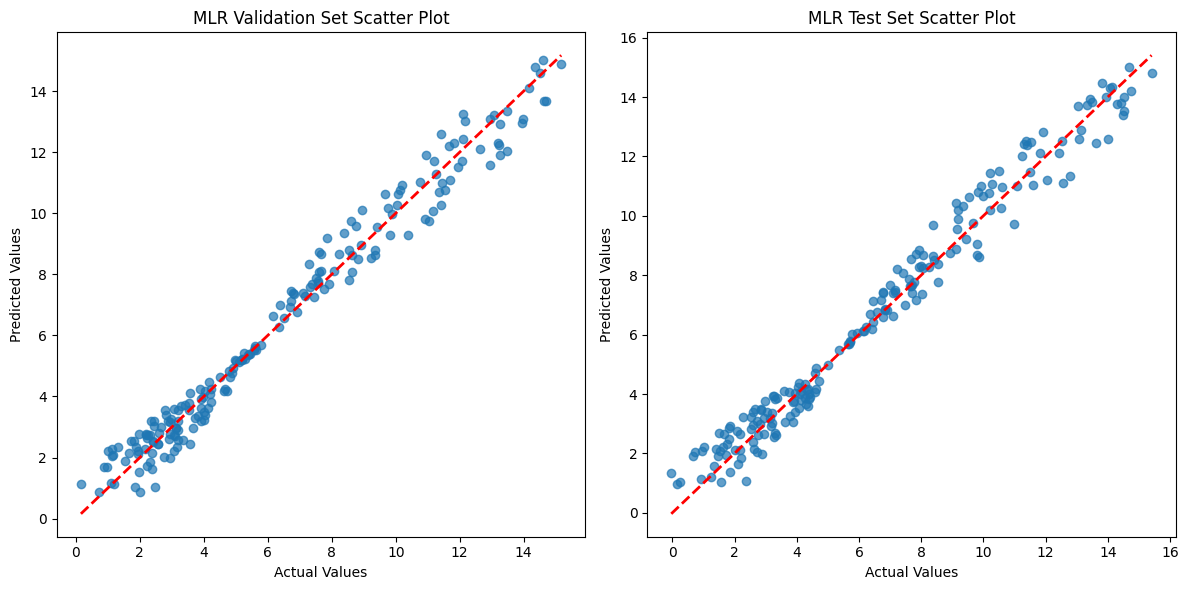

In [4]:
plt.figure(figsize=(12, 6))

# Validation set scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_val, mlr_val_pred, alpha=0.7)
plt.title('MLR Validation Set Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2)

# Test set scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, mlr_test_pred, alpha=0.7)
plt.title('MLR Test Set Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

MAPE on Test Set (BP): 78.64775007265602%
MAPE on Validation Set (BP): 96.06207278421789%


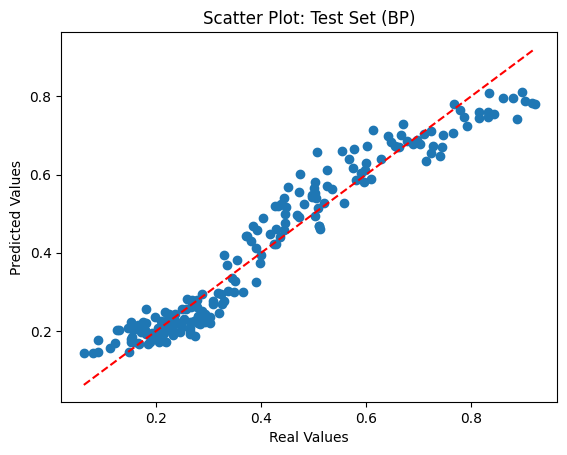

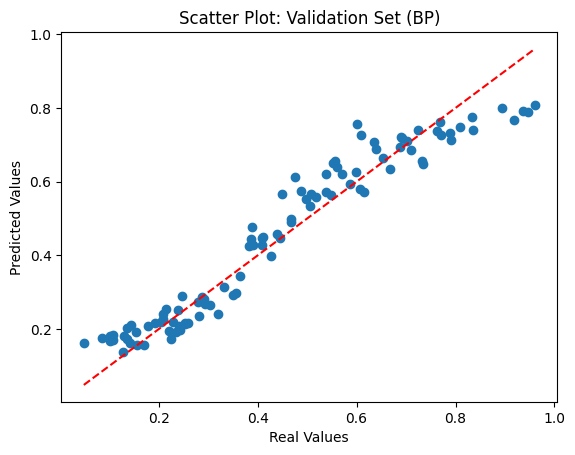

In [17]:

normalized_data = normalize_data(data)
X, y = split_features_targets(normalized_data)
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)

X_train = np.atleast_2d(X_train)
y_train = np.atleast_2d(y_train)

if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if y_train.ndim == 1:
    y_train = y_train.reshape(-1, 1)


# Initialize and train the neural network
nn = NeuralNetwork([X_train.shape[1], 10, 1])  # Example architecture
nn.train(list(zip(X_train, y_train)), epochs=100, mini_batch_size=10, eta=0.1)
# Evaluate the neural network
predictions_bp_test = nn.feedforward(X_test.T)[0][-1].flatten()
predictions_bp_val = nn.feedforward(X_val.T)[0][-1].flatten()




mape_bp_test = mean_absolute_percentage_error(y_test, predictions_bp_test)
mape_bp_val = mean_absolute_percentage_error(y_val, predictions_bp_val)

print(f'MAPE on Test Set (BP): {mape_bp_test}%')
print(f'MAPE on Validation Set (BP): {mape_bp_val}%')

# Scatter plot for Test Set
plt.scatter(y_test, predictions_bp_test)
plt.title('Scatter Plot: Test Set (BP)')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.show()

# Scatter plot for Validation Set
plt.scatter(y_val, predictions_bp_val)
plt.title('Scatter Plot: Validation Set (BP)')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red')
plt.show()
